# Train end-to-end model with SSL4EO backbone

In [ ]:
import timm
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set up PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

# Set seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Load the dataset
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))
img_dir = os.path.join(DATA_DIR, 'dhs_images')

### Make folds

In [3]:
# Create equal-sized folds
folds = ['A', 'B', 'C', 'D', 'E']
df['cv_fold'] = np.nan  # Initialize the cv_fold column

# Generate and shuffle indices
indices = np.arange(len(df))
np.random.shuffle(indices)

# Split indices into equal-sized groups and assign folds
fold_indices = np.array_split(indices, len(folds))
for fold, idx in zip(folds, fold_indices):
    df.loc[idx, 'cv_fold'] = fold

df['cv_fold'].value_counts()

C    13724
B    13724
D    13724
A    13724
E    13723
Name: cv_fold, dtype: int64

### Init model

Initiate model. For more info, see https://huggingface.co/torchgeo/ssl4eo_landsat/tree/main

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def init_model():

    repo_id = "torchgeo/ssl4eo_landsat"
    filename = "resnet50_landsat_etm_sr_moco-1266cde3.pth"

    # Download the model weights
    backbone_path = hf_hub_download(repo_id=repo_id, filename=filename)

    # Create backbone model
    state_dict = torch.load(backbone_path)
    ssl4eo_backbone = timm.create_model("resnet50", in_chans=6, num_classes=0)
    ssl4eo_backbone.load_state_dict(state_dict)

    # Define model with regression head
    model = nn.Sequential(
        ssl4eo_backbone,
        nn.Dropout(p=0.2), # Dropout layer to prevent overfitting
        nn.Linear(2048, 1)
    ).to(device, memory_format=torch.channels_last) # Use channels_last memory format for better performance on GPUs

    return model

### Data loader

Code for dataloader

In [5]:
class RegressionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cluster_id = self.df.iloc[idx]['cluster_id']
        img_path = os.path.join(self.img_dir, cluster_id, 'landsat.np')
        img = np.load(img_path)
        target = (self.df.iloc[idx]['iwi'] / 100)
        if self.transform:
            img = self.transform(img)
        return img, target

In [6]:
def get_dataloaders(df, img_dir, train_folds, val_fold, test_fold, batch_size=128, num_workers=16):

    # Get the indices for each fold
    train_folds = df[df['cv_fold'].isin(train_folds)].index.tolist()
    val_fold = df[df['cv_fold'] == val_fold].index.tolist()
    test_fold = df[df['cv_fold'] == test_fold].index.tolist()

    landsat_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 0.0000275 - 0.2),
        transforms.Lambda(lambda x: torch.clamp(x, 0.0, 0.3)),
        transforms.Lambda(lambda x: x / 0.3)
    ])

    train_transform = transforms.Compose([
        landsat_transform,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
    ])

    train_dataset = RegressionDataset(df=df.iloc[train_folds], img_dir=img_dir, transform=train_transform)
    val_dataset = RegressionDataset(df=df.iloc[val_fold], img_dir=img_dir, transform=landsat_transform)
    test_dataset = RegressionDataset(df=df.iloc[test_fold], img_dir=img_dir, transform=landsat_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, val_dataloader, test_dataloader

Train model

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4, weight_decay=1e-5, T_0=5, T_mult=2, device=device):

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)
    scaler = GradScaler()
    best_val_loss = float('inf')
    best_model_state = model.state_dict()

    progress_bar = tqdm(range(num_epochs), desc="Training Progress")

    for epoch in progress_bar:
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            targets = targets.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs).squeeze()  # remove extra dim if needed
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
                targets = targets.to(device, dtype=torch.float32)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
        progress_bar.set_postfix({
            'Train Loss': epoch_loss,
            'Val Loss': val_loss,
            'Best Val Loss': best_val_loss
        })
    
    model.load_state_dict(best_model_state)
    return model

In [ ]:
for fold in folds:
    print(f"Training for fold {fold}...")

    # Define train, validation, and test folds
    test_fold = fold
    val_fold = folds[(folds.index(fold) + 1) % len(folds)]
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    print(f"Train folds: {train_folds}, Validation fold: {val_fold}, Test fold: {test_fold}")

    # Get dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df, img_dir, train_folds, val_fold, test_fold)

    # Initialize model
    model = init_model()

    # Train the model
    model = train_model(model, train_dataloader, val_dataloader, num_epochs=20)

    # Save the model
    torch.save(model.state_dict(), os.path.join(DATA_DIR, 'cv_models', f'model_fold_{fold}.pth'))

    # Get test predictions
    print(f"Generating predictions for fold {test_fold}...")
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            test_predictions.extend(outputs.cpu().numpy())
    test_predictions = np.array(test_predictions)

    # Store predictions in the dataframe
    df.loc[df['cv_fold'] == test_fold, 'iwi_hat'] = test_predictions * 100  # Scale back to original range

# Save predictions to CSV
df.to_csv(os.path.join(DATA_DIR, 'dhs_with_imgs_predictions.csv'), index=False)

Training for fold A...
Train folds: ['C', 'D', 'E'], Validation fold: B, Test fold: A


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

R^2 Score: 0.7390


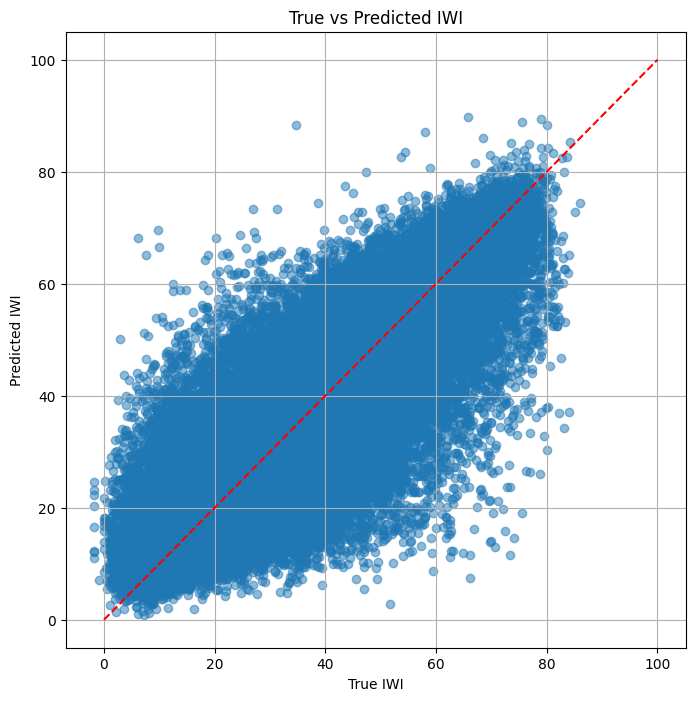

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(df['iwi'].values, df['iwi_hat'].values, alpha=0.5)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('True vs Predicted IWI')
plt.grid()

# Get R^2
from sklearn.metrics import r2_score
r2 = r2_score(df['iwi'].values, df['iwi_hat'].values)
print(f"R^2 Score: {r2:.4f}")

## Plot results

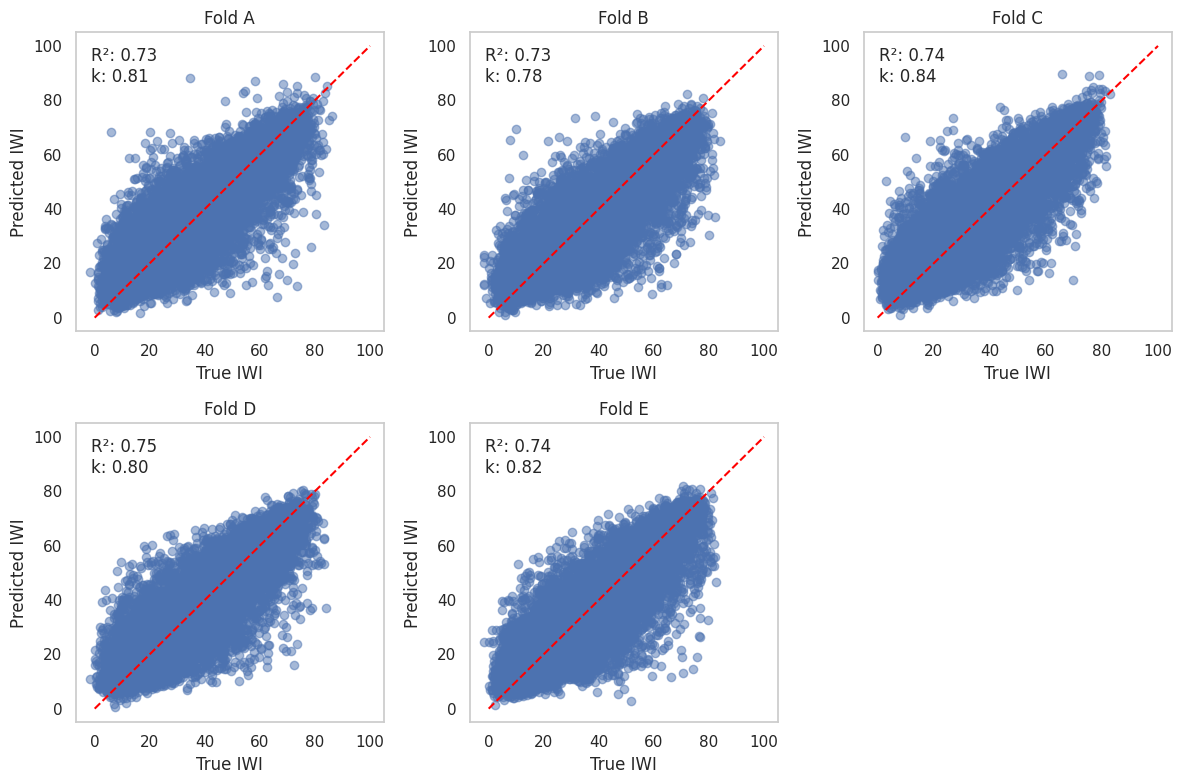

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

sns.set(style='whitegrid')

# Plot the sctatter plots for each fold in subplots
plt.figure(figsize=(12, 8))
for i, fold in enumerate('ABCDE'):
    plt.subplot(2, 3, i + 1)
    fold_data = df[df['cv_fold'] == fold]
    plt.scatter(fold_data['iwi'], fold_data['iwi_hat'], alpha=0.5)
    plt.plot([0, 100], [0, 100], color='red', linestyle='--')

    # Add a box with R^2 and RMSE
    r2 = r2_score(fold_data['iwi'], fold_data['iwi_hat'])
    slope_model = LinearRegression().fit(fold_data['iwi'].values.reshape(-1, 1), fold_data['iwi_hat'])
    plt.text(0.05, 0.95, f'R²: {r2:.2f}\nk: {slope_model.coef_[0]:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.xlabel('True IWI')
    plt.ylabel('Predicted IWI')
    plt.title(f'Fold {fold}')
    plt.grid()
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Residuals (True - Predicted)')

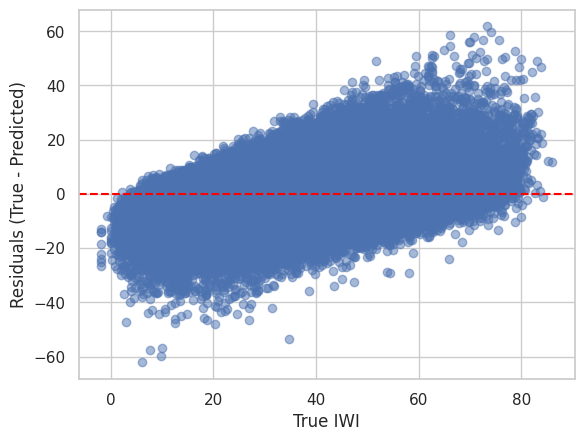

In [7]:
plt.scatter(df['iwi'], df['iwi'] - df['iwi_hat'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Residuals (True - Predicted)')